In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
#import numpy as np
#from sklearn import metrics
#import math

#import stuff for gradCAM
#import matplotlib.cm as cm
#from IPython.display import Image

#Set GPU to use
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.4.1


In [2]:
#code for GPU mem growth

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [4]:
#data
df = pd.read_csv('../data/SedMLdata.csv')
df.head()

,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm,skew,kurtosis
0,F1crop1.jpg,0.202,0.255,0.328,0.417,0.600,1.049,1.475,1.690,1.941,2.243,2.621,-0.310,0.992
1,F1crop2.jpg,0.168,0.194,0.224,0.256,0.305,0.481,0.974,1.420,2.143,2.982,3.980,0.298,0.965
2,F1crop3.jpg,0.128,0.144,0.160,0.176,0.198,0.304,0.540,0.700,0.897,1.172,1.598,0.247,0.857
3,F1crop4.jpg,0.218,0.273,0.346,0.429,0.621,1.283,1.821,2.040,2.241,2.532,2.873,-0.398,0.850
4,F1crop5.jpg,0.134,0.153,0.174,0.194,0.221,0.332,0.780,1.139,1.532,1.851,2.376,0.384,0.810


In [5]:
#build data generators for training and validaton

split = 0.5

df = pd.read_csv('../data/SedMLdata.csv')
columns=["D2mm", "D5mm", "D10mm", "D16mm",
"D25mm","D50mm", "D75mm", "D84mm", "D90mm",
"D95mm", "D98mm", "skew", "kurtosis"]

# Define dirs and files
train_data_dir = '../data/CropPics'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 4

#set Image size (RGB so imshape is 3)
pix_dim = 1024
imsize = (pix_dim, pix_dim) 
imshape = (pix_dim, pix_dim, 3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_dataframe(dataframe = df,
                                                    directory = train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'raw',
                                                    x_col = 'CropName',
                                                    y_col = columns,
                                                    target_size = imsize,
                                                    color_mode = 'rgb',
                                                    subset = 'training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_dataframe(dataframe=df,
                                                          directory = train_data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = columns,
                                                          target_size = imsize,
                                                          color_mode = 'rgb',
                                                          subset = 'validation')

Found 150 validated image filenames.
Found 150 validated image filenames.


Stats :
[0.181 0.207 0.233 0.255 0.283 0.361 0.485 0.577 0.689 0.985 3.601 0.216
 1.187]


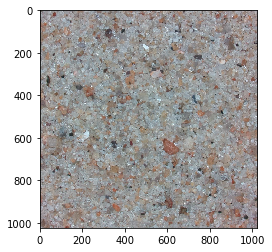

Stats :
[0.179 0.2   0.222 0.24  0.263 0.32  0.386 0.424 0.461 0.517 0.618 0.002
 1.012]


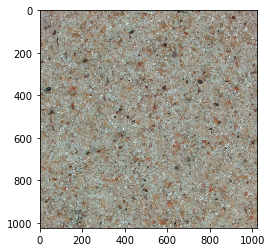

Stats :
[0.128 0.144 0.16  0.176 0.198 0.304 0.54  0.7   0.897 1.172 1.598 0.247
 0.857]


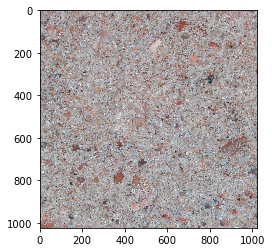

Stats :
[0.201 0.23  0.262 0.292 0.331 0.45  0.747 1.011 1.25  1.554 1.748 0.302
 0.961]


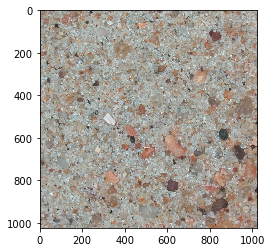

In [6]:
#show augs
x= validation_generator.next()

for i in range(0,batch_size):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    plt.imshow(image)
    print('Stats :')
    print(x[1][i])
    plt.show()

In [7]:
total_train = 150
total_val = 150

In [8]:
#model

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=imshape),
    layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.GlobalMaxPooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(13, activation="linear")
])


model._name = "SandCam_CNN"

model.summary()


Model: "SandCam_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1024, 1024, 32)    896       
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 1024, 32)    128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 512, 512, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 64)      

In [9]:
# #determine the learning rate

# callbacks = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/10))

# model.compile(loss = 'mean_squared_error',
#              optimizer = tf.keras.optimizers.Adam(lr = 1e-8),
#              metrics = mae_metric)

# history = model.fit(train_generator,
#                     steps_per_epoch = total_train // batch_size,
#                     validation_data = validation_generator,
#                     epochs= 100,
#                     workers = 8,
#                     validation_steps =  total_val // batch_size,
#                     callbacks =[callbacks])

In [10]:
#LOSS CURVE

In [11]:
# define other metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError(name='mae')

In [12]:
#compile
model.compile(loss='mean_squared_error', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics = mae_metric
             )

In [13]:
# define a callback

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 10, 
                                             restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.2,
                                                 verbose = 1,
                                                 patience=5)

In [14]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 50,
                    workers = 8,
                    validation_steps =  total_val // batch_size,
                    callbacks =[early_stop, reduce_lr])

Epoch 1/50
37/37 [==============================] - 21s 412ms/step - loss: 47.5650 - mae: 4.6818 - val_loss: 1.4031 - val_mae: 0.7828
Epoch 2/50
37/37 [==============================] - 13s 360ms/step - loss: 0.9736 - mae: 0.6927 - val_loss: 1.5412 - val_mae: 0.8478
Epoch 3/50
37/37 [==============================] - 14s 368ms/step - loss: 0.7453 - mae: 0.5925 - val_loss: 1.7215 - val_mae: 0.9693
Epoch 4/50
37/37 [==============================] - 14s 376ms/step - loss: 0.7658 - mae: 0.5659 - val_loss: 1.8224 - val_mae: 1.0339
Epoch 5/50
37/37 [==============================] - 14s 381ms/step - loss: 0.6340 - mae: 0.5266 - val_loss: 1.8584 - val_mae: 1.0616
Epoch 6/50
37/37 [==============================] - 14s 386ms/step - loss: 0.6981 - mae: 0.5378 - val_loss: 1.6086 - val_mae: 0.9675
Epoch 7/50
37/37 [==============================] - 14s 384ms/step - loss: 0.7351 - mae: 0.5432 - val_loss: 1.4528 - val_mae: 0.8933
Epoch 8/50
37/37 [==============================] - 15s 396ms/step -

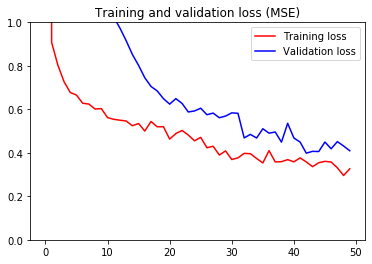

<Figure size 432x288 with 0 Axes>

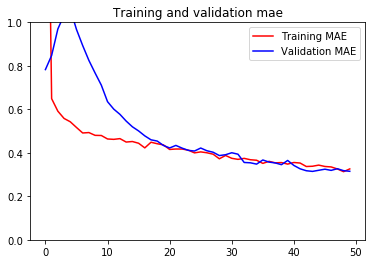

<Figure size 432x288 with 0 Axes>

In [15]:
#look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,1)

plt.title('Training and validation loss (MSE)')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs, mae, 'r', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.ylim(0,1)

plt.title('Training and validation mae')
plt.legend(loc=0)
plt.figure()
plt.show()


In [16]:
#save the model
filepath = './models/SNmodel'
model.save(filepath)


INFO:tensorflow:Assets written to: ./models/SNmodel/assets


In [ ]:
# #model size
# model.save("./models/SNmodel.h5")
# model_file ='./models/SNmodel.h5'
# b = os.path.getsize(model_file)
# print ("Size(mb): %d" % (b/1000000))

In [ ]:
#prune

In [ ]:
#quantize

In [ ]:
#test Quantize